In [1]:
import pandas as pd 

In [2]:
pwd

'/Users/parkseongtae/Desktop/instacart/instacart -p'

In [3]:
cd /Users/'parkseongtae'/Desktop/instacart

/Users/parkseongtae/Desktop/instacart


In [4]:
ord = pd.read_csv('orders.csv')

In [5]:
ord.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
# 기본 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 

/opt/anaconda3/envs/Modulabs/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/Modulabs/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


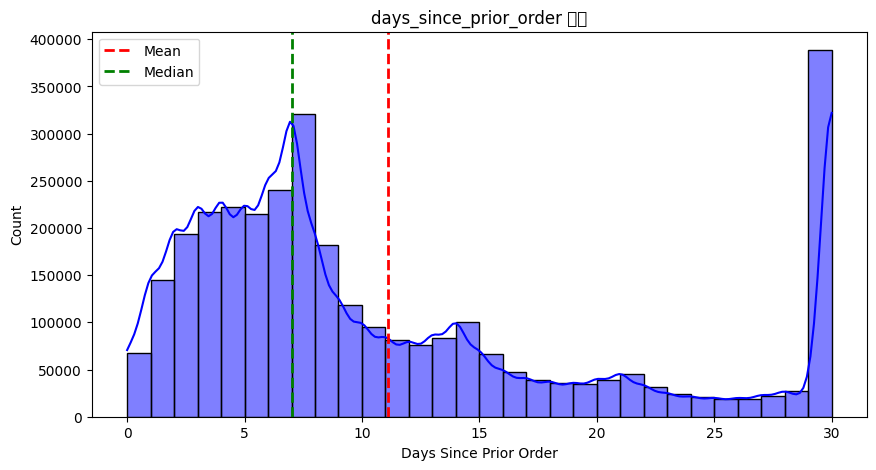

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(ord["days_since_prior_order"].dropna(), bins=30, kde=True, color='blue')
plt.axvline(ord["days_since_prior_order"].mean(), color='red', linestyle='dashed', linewidth=2, label="Mean")
plt.axvline(ord["days_since_prior_order"].median(), color='green', linestyle='dashed', linewidth=2, label="Median")
plt.title("days_since_prior_order 분포")
plt.xlabel("Days Since Prior Order")
plt.ylabel("Count")
plt.legend()
plt.show() 

# 고객군별 구매 간격 및 패턴 분석 

필요 컬럼 

user_id, order_number, days_since_prior_order


In [8]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
ord = pd.read_csv('order2.csv')

In [10]:
ord.head()

,user_id,order_number,days_since_prior_order
0,1,1,NaN
1,1,2,15.0
2,1,3,21.0
3,1,4,29.0
4,1,5,28.0


In [11]:
# order_number가 1이고, days_since_prior_order가 NaN인 행 필터링
df_nan_orders = ord[(ord["order_number"] == 1) & (ord["days_since_prior_order"].isna())]

# 결과 확인
print(df_nan_orders)

         user_id  order_number  days_since_prior_order
0              1             1                     NaN
11             2             1                     NaN
26             3             1                     NaN
39             4             1                     NaN
45             5             1                     NaN
...          ...           ...                     ...
3420930   206205             1                     NaN
3420934   206206             1                     NaN
3421002   206207             1                     NaN
3421019   206208             1                     NaN
3421069   206209             1                     NaN

[206209 rows x 3 columns]


In [12]:
# order_number가 1이 아니면서, days_since_prior_order가 NaN인 행 필터링
df_nan_orders = ord[(ord["order_number"] != 1) & (ord["days_since_prior_order"].isna())]

# 결과 확인
print(df_nan_orders) 

Empty DataFrame
Columns: [user_id, order_number, days_since_prior_order]
Index: []


In [13]:

# 최대 Recency 값 계산
max_recency = ord['days_since_prior_order'].max()

# 신규 고객 처리: order_number == 1 → Recency를 max_recency * 1.2로 설정
ord['Recency'] = ord.apply(lambda row: max_recency * 1.2 if row['order_number'] == 1 else row['days_since_prior_order'], axis=1)

# 고객 단위 그룹화 (최소 Recency 및 최대 Frequency 계산)
rf_df = ord.groupby('user_id').agg(
    Recency=('Recency', 'min'),  # 가장 최근 주문과의 차이 (최소값) 
    Frequency=('order_number', 'max')  # 총 주문 횟수 (최대 주문 번호)
).reset_index()

# 결과 출력
print(rf_df.head())  # 상위 5개 데이터 확인 

   user_id  Recency  Frequency
0        1      0.0         11
1        2      3.0         15
2        3      7.0         13
3        4      0.0          6
4        5      6.0          5


In [14]:
# K-Means 클러스터링 수행
X = rf_df[['Frequency', 'Recency']] 

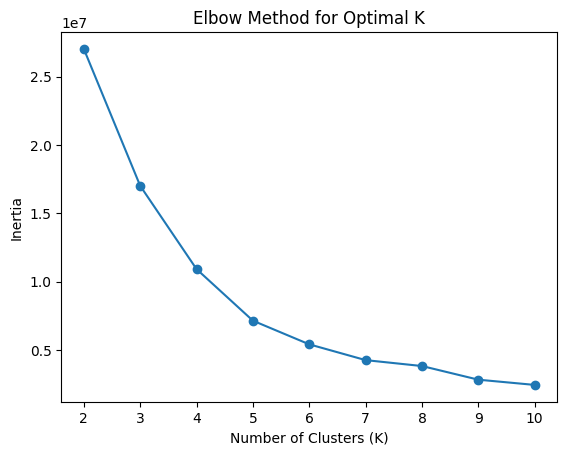

In [15]:
# 최적의 K값 찾기 (엘보우 방법)
inertia = []
k_range = range(2, 11)  # K=2~10 시도
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show() 

In [16]:
# K-Means 클러스터링 수행 (K=4 설정)
X = rf_df[['Frequency', 'Recency']]
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rf_df['cluster'] = kmeans.fit_predict(X) 

In [17]:
# 클러스터별 평균값 확인
cluster_summary = rf_df.groupby('cluster').agg(
    avg_frequency=('Frequency', 'mean'),
    avg_recency=('Recency', 'mean'),
    count=('cluster', 'count')
).reset_index()
print(cluster_summary) 

   cluster  avg_frequency  avg_recency   count
0        0       9.937272     4.397587  127391
1        1      70.941905     0.384489   10328
2        2      31.735360     1.595683   39892
3        3       5.472026    20.134870   28598


In [18]:
# VIP 고객 군집 선정: 가장 높은 Frequency & 낮은 Recency (재구매율 높은 고객)
vip_cluster = cluster_summary.sort_values(['avg_frequency', 'avg_recency'], ascending=[False, True]).iloc[0]['cluster']
rf_df['is_vip'] = (rf_df['cluster'] == vip_cluster).astype(int)


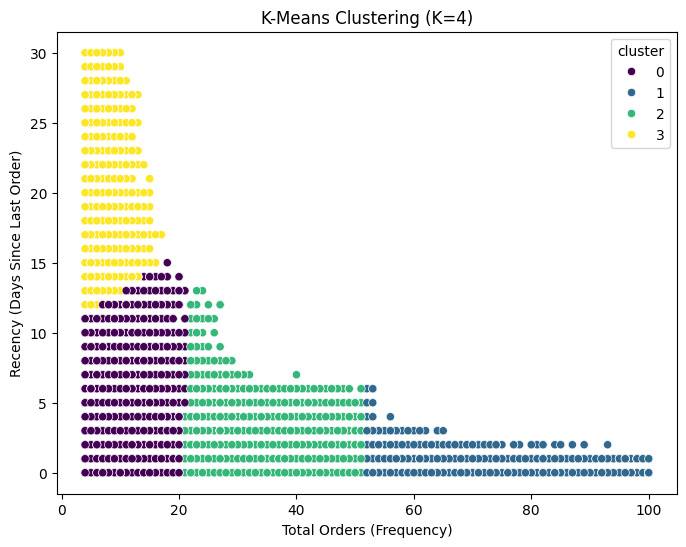

In [19]:
# 클러스터링 결과 시각화 (산점도)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=rf_df['Frequency'], y=rf_df['Recency'], hue=rf_df['cluster'], palette='viridis')
plt.title('K-Means Clustering (K=4)')
plt.xlabel('Total Orders (Frequency)')
plt.ylabel('Recency (Days Since Last Order)')
plt.show() 

# -1 로 NAN 값 처리 

In [20]:
ord = pd.read_csv('order2.csv') 

In [21]:
# NaN을 -1로 변환 (신규 고객 구분)
ord['days_since_prior_order'] = ord['days_since_prior_order'].fillna(-1)


In [22]:
# 고객별 Recency (최소 주문 간격), Frequency (총 주문 횟수)
customer_df = ord.groupby('user_id').agg(
    Recency=('days_since_prior_order', 'min'),
    Frequency=('order_number', 'max')
).reset_index()

In [23]:
# K-Means 클러스터링 수행 (K=4 설정)
X = customer_df[['Frequency', 'Recency']]
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_df['cluster'] = kmeans.fit_predict(X) 

In [24]:
# 클러스터별 평균값 확인
cluster_summary = customer_df.groupby('cluster').agg(
    avg_frequency=('Frequency', 'mean'),
    avg_recency=('Recency', 'mean'),
    count=('cluster', 'count')
).reset_index()
print(cluster_summary) 

   cluster  avg_frequency  avg_recency   count
0        0      21.741275         -1.0   50030
1        1      83.241405         -1.0    5468
2        2      45.230314         -1.0   19582
3        3       7.568905         -1.0  131129


In [25]:
# VIP 고객 군집 선정: 가장 높은 Frequency & 낮은 Recency (재구매율 높은 고객)
vip_cluster = cluster_summary.sort_values(['avg_frequency', 'avg_recency'], ascending=[False, True]).iloc[0]['cluster']
customer_df['is_vip'] = (customer_df['cluster'] == vip_cluster).astype(int)

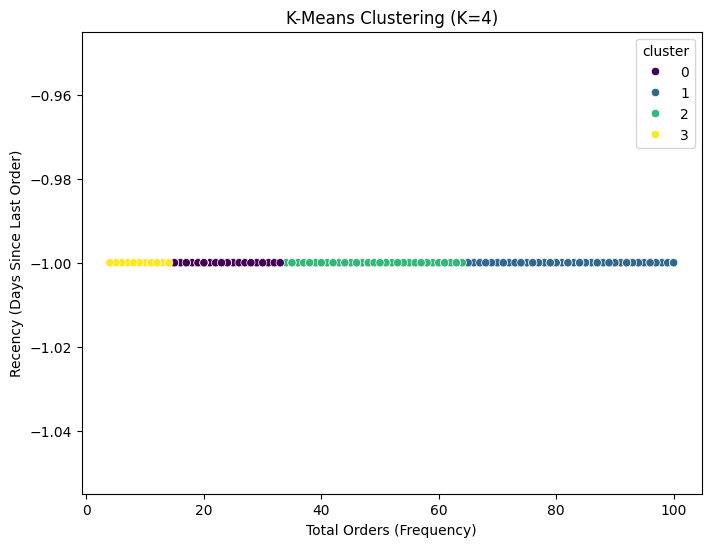

In [26]:
# 클러스터링 결과 시각화 (산점도)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=customer_df['Frequency'], y=customer_df['Recency'], hue=customer_df['cluster'], palette='viridis')
plt.title('K-Means Clustering (K=4)')
plt.xlabel('Total Orders (Frequency)')
plt.ylabel('Recency (Days Since Last Order)')
plt.show() 

# 그냥 K-means

In [27]:
ord = pd.read_csv('order2.csv') 

In [28]:
# NaN 처리: 신규 고객의 days_since_prior_order를 max_recency * 1.2로 설정
max_recency = ord['days_since_prior_order'].max()
ord['days_since_prior_order'] = ord['days_since_prior_order'].fillna(max_recency * 1.2) 

In [29]:
# K-Means 클러스터링을 위한 데이터 준비
X = ord[['order_number', 'days_since_prior_order']]

In [30]:
# K-Means 클러스터링 수행 (K=4 설정)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
ord['cluster'] = kmeans.fit_predict(X) 

In [31]:
# 클러스터별 평균값 확인
cluster_summary = ord.groupby('cluster').agg(
    avg_order_number=('order_number', 'mean'),
    avg_days_since_prior=('days_since_prior_order', 'mean'),
    count=('cluster', 'count')
).reset_index()
print(cluster_summary) 

   cluster  avg_order_number  avg_days_since_prior    count
0        0          5.844086             29.335561   841258
1        1          9.290487              7.778113  1604939
2        2         31.503779              6.795983   735429
3        3         65.533064              4.160192   239457


/opt/anaconda3/envs/Modulabs/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


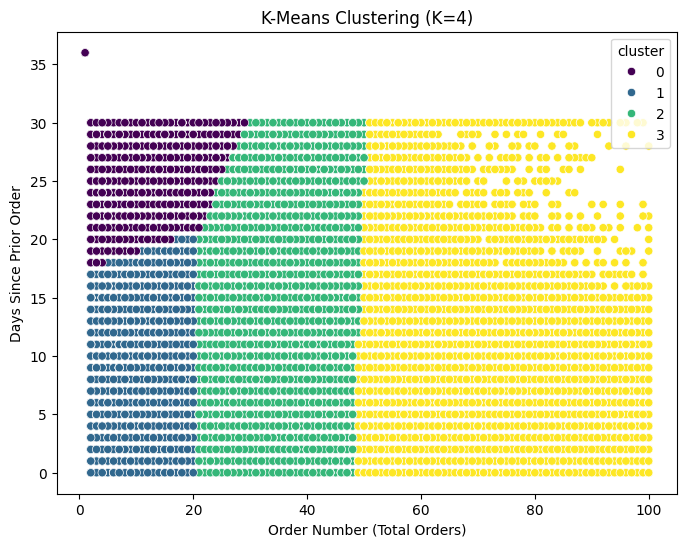

In [32]:
# 클러스터링 결과 시각화 (산점도)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=ord['order_number'], y=ord['days_since_prior_order'], hue=ord['cluster'], palette='viridis')
plt.title('K-Means Clustering (K=4)')
plt.xlabel('Order Number (Total Orders)')
plt.ylabel('Days Since Prior Order')
plt.show() 